# Notebook 2: Blob Finding and Watershed Segmentation of Large Structures

In this notebook we will begin to use our reduced image to segment and define cloud structures.

Most of the tools we will need come from the the Python image processing package scikit-image.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.feature import blob_dog
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import regionprops
import regions as rg
import astropy.units as u
from astropy.nddata.utils import Cutout2D
import scipy.ndimage
import sys as os
os.path.append("%SURP_DIR%/RawData")

Once again we will open our fits file like before but this time the reduced image.

In [2]:

hdulist = fits.open("M82_JWST_reduced.fits")
header = hdulist[0].header
imdat = hdulist[0].data
print(type(imdat))
image_whole = imdat
wcs = WCS(hdulist[0].header)

<class 'numpy.ndarray'>


Set DATE-AVG to '2023-12-31T19:43:39.963' from MJD-AVG.
Set DATE-END to '2024-01-01T01:32:08.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.864333 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694877744.107 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


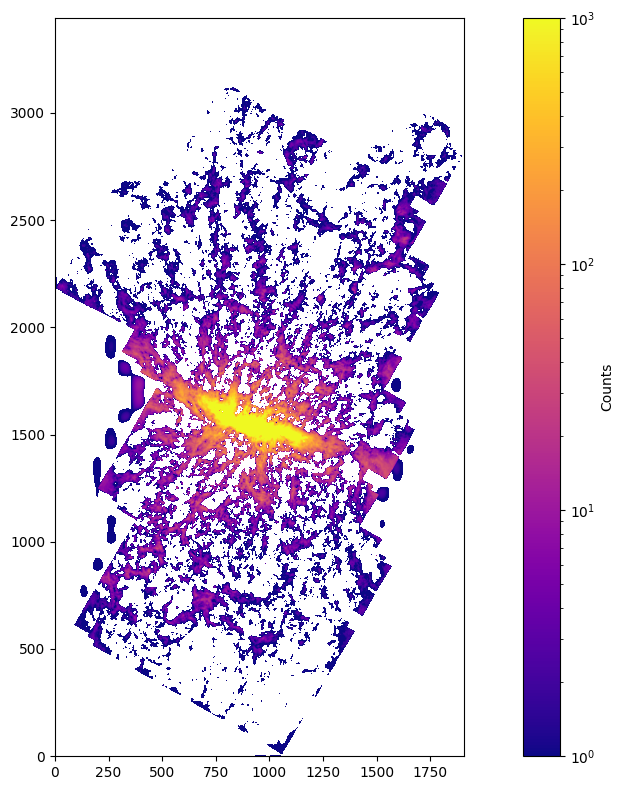

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(imdat,norm=LogNorm(vmin=1, vmax=1000),origin='lower',cmap='plasma')
fig.colorbar(im,label="Counts", orientation="vertical") 
plt.tight_layout() 
plt.show()

Below is the actual segmenation code.

First thing we do is import the region file. The region file draws a box over the image and what we use it for is to mask everything outside of it.
We do this for the northern and southern outflow. 

Next we rotate the image slightly by 15 degrees using the scipy.ndimage.rotate function.

Next we find local maxima throughout the image to send over to the watershed algorithm. The function is called blob_dog and you can read about it here: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

To adjust the segmentation you alter the min_sigma and max_sigma commands. The min_sigma commmand controls how small the structures can be and the max_sigma controls how big they can be. I suggest only adjusting one at time.

Then the array of local maxima from blob_dog is sent to the watershed function that will actually segment the image.

### To-Do

What you need to do now is the following: 
1. Crop the image so you only get the actual emission and not the random stuff around the data. (hint: use np.where)
2. Adjust min and max sigma to segment the structures well, not too small, not too big.
3. Adjust the font size of the structure labels to better suit the image.
4. Delete unwanted clouds (hint: The segmentation array simply has numbers from 1 to the max cloud number. Simply make a list of clouds to be removed and set those values in the segmentation array to 0)

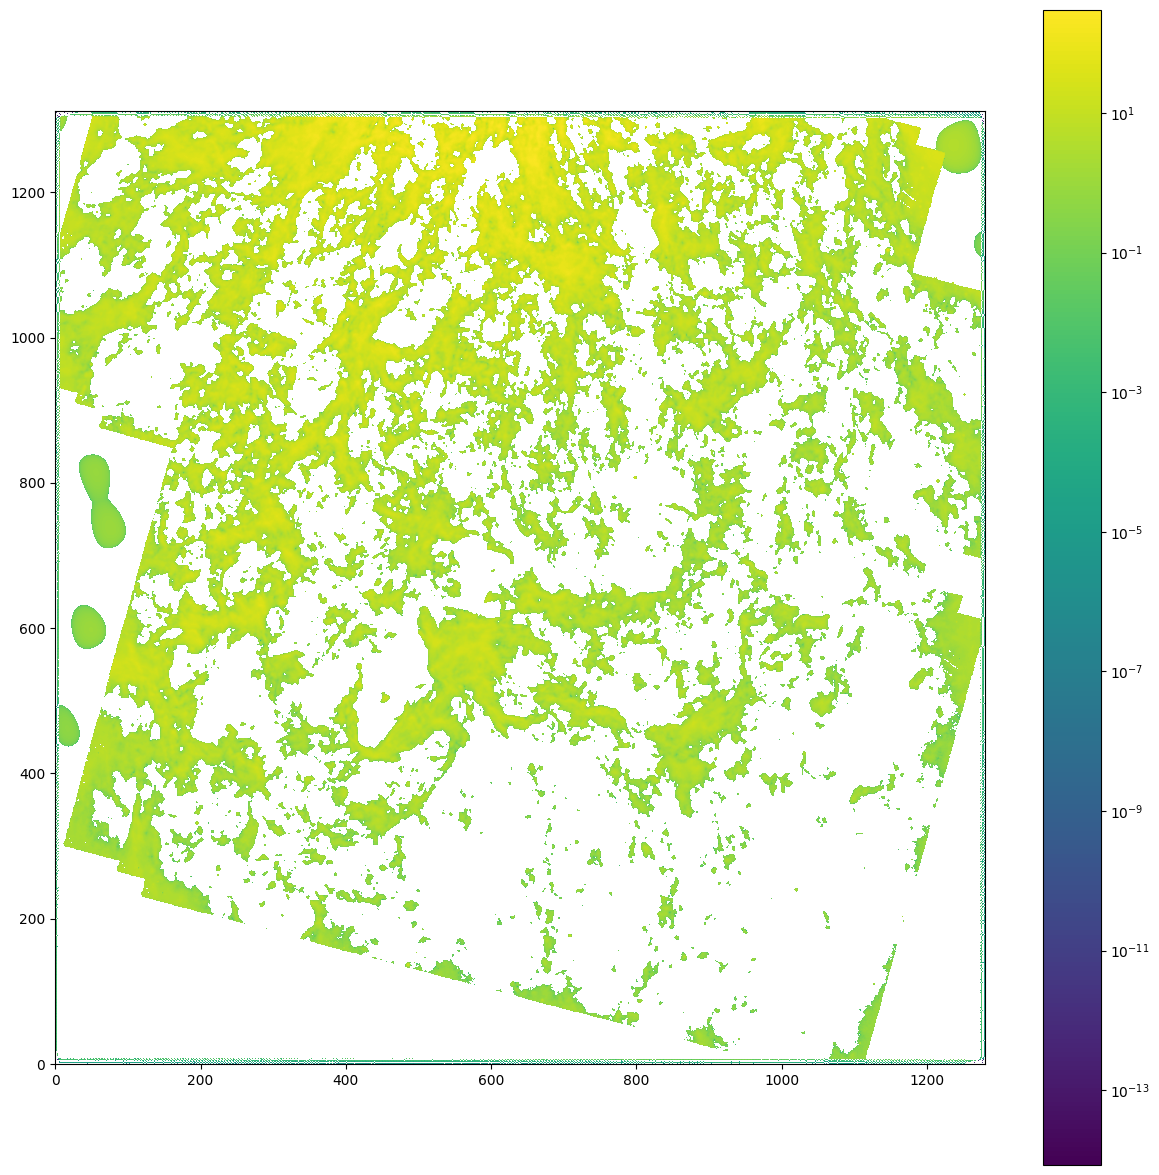

(409, 3)
(1313, 1280, 3)


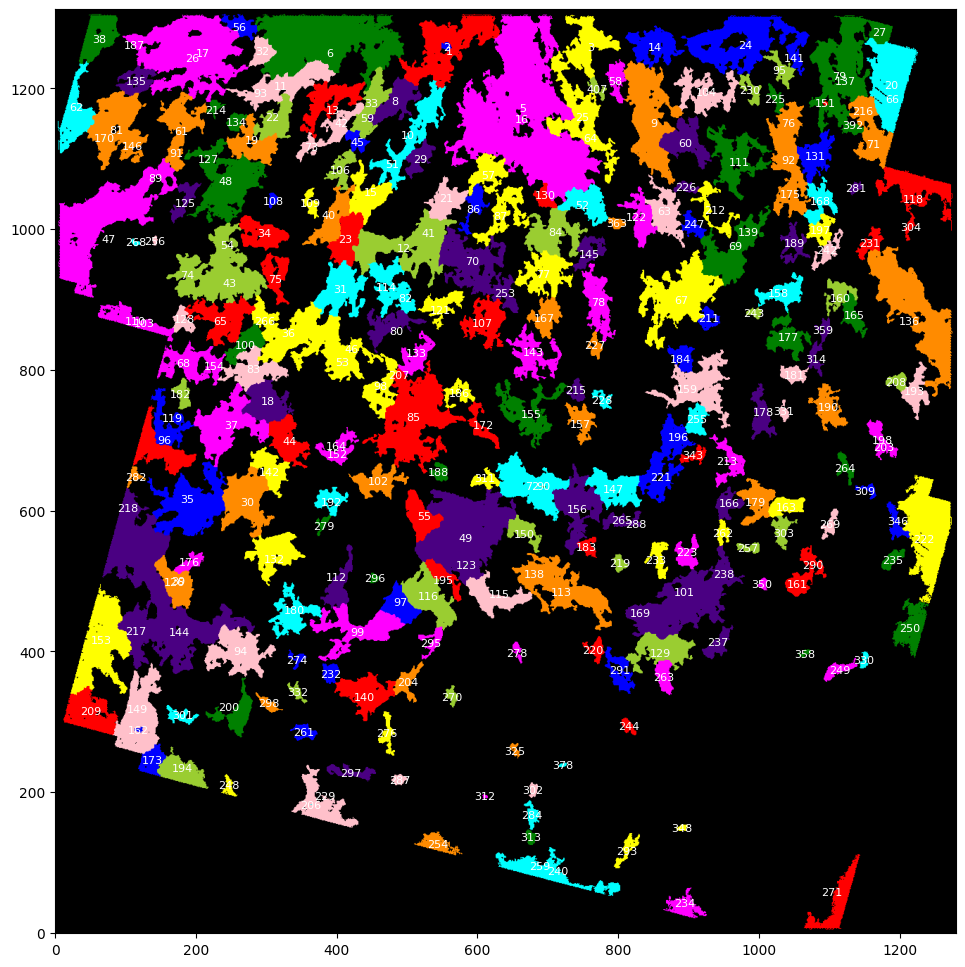

In [4]:
test_reg = rg.Regions.read('./M82_JWST_regions.reg', format="ds9") #Open region file
reg_str = ['south','north']

#for largereg,rgname in zip(test_reg,reg_str):

reg1 = test_reg[0] #index 0 is south region
mask = reg1.to_mask()
data = mask.cutout(image_whole) 

size = u.Quantity(data.shape, u.pixel)
cutout = Cutout2D(imdat, reg1.center.xy, size, wcs=wcs)
im_mask= mask*cutout.data #crops the image to only be the south region

rotated_im = scipy.ndimage.rotate(im_mask, angle=-15, reshape=False) #Rotate the image to align with the disk
fig, ax = plt.subplots(figsize=(15,15))


non_zero_indecies = np.where(rotated_im > 0.0001)
min_x, max_x = np.min(non_zero_indecies[1]), np.max(non_zero_indecies[1])
min_y, max_y = np.min(non_zero_indecies[0]), np.max(non_zero_indecies[0])
rotated_im = rotated_im[min_y:max_y+1, min_x:max_x+1] #These lines cut out the garbage around the edge of the image created by the rotation
imax = ax.imshow(rotated_im ,origin='lower', norm=LogNorm())
fig.colorbar(imax)
plt.show()
plt.close()

blobs = blob_dog(rotated_im, min_sigma=12, max_sigma=50, threshold=0.001) #Find regions of high intensity

fig, ax = plt.subplots(figsize=(16,12))
# Convert blob coordinates to integers
blobs = np.round(blobs).astype(int)
print(blobs.shape)
# Create a labeled array for the blobs
labeled_clumps = np.zeros_like(rotated_im, dtype=int)
# Assign unique labels to the blobs

for i, (y, x, sigma) in enumerate(blobs):
    labeled_clumps[y,x] = i + 1

segmentationSouth = watershed(-rotated_im, labeled_clumps, mask=(rotated_im > 0.001))
bad_values = [267, 241, 171, 205]
for i in bad_values:
     segmentationSouth = np.where(segmentationSouth != i, segmentationSouth, 0)
seg_overlay = label2rgb(segmentationSouth, bg_label=0)
print(np.shape(seg_overlay))
im = ax.imshow(seg_overlay, origin='lower')
for label_value in np.unique(segmentationSouth):

        if label_value == 0:
            continue  # Skip the background label
        # Extract coordinates of the labeled component
        coords = np.argwhere(segmentationSouth == label_value)
        # Find the bounding box
        min_y, min_x = np.min(coords, axis=0)
        max_y, max_x = np.max(coords, axis=0)
        # Calculate the center of the bounding box
        y, x = (min_y + max_y) / 2, (min_x + max_x) / 2
        plt.text(x, y, str(label_value), color='white', fontsize=8, ha='center', va='center')


407


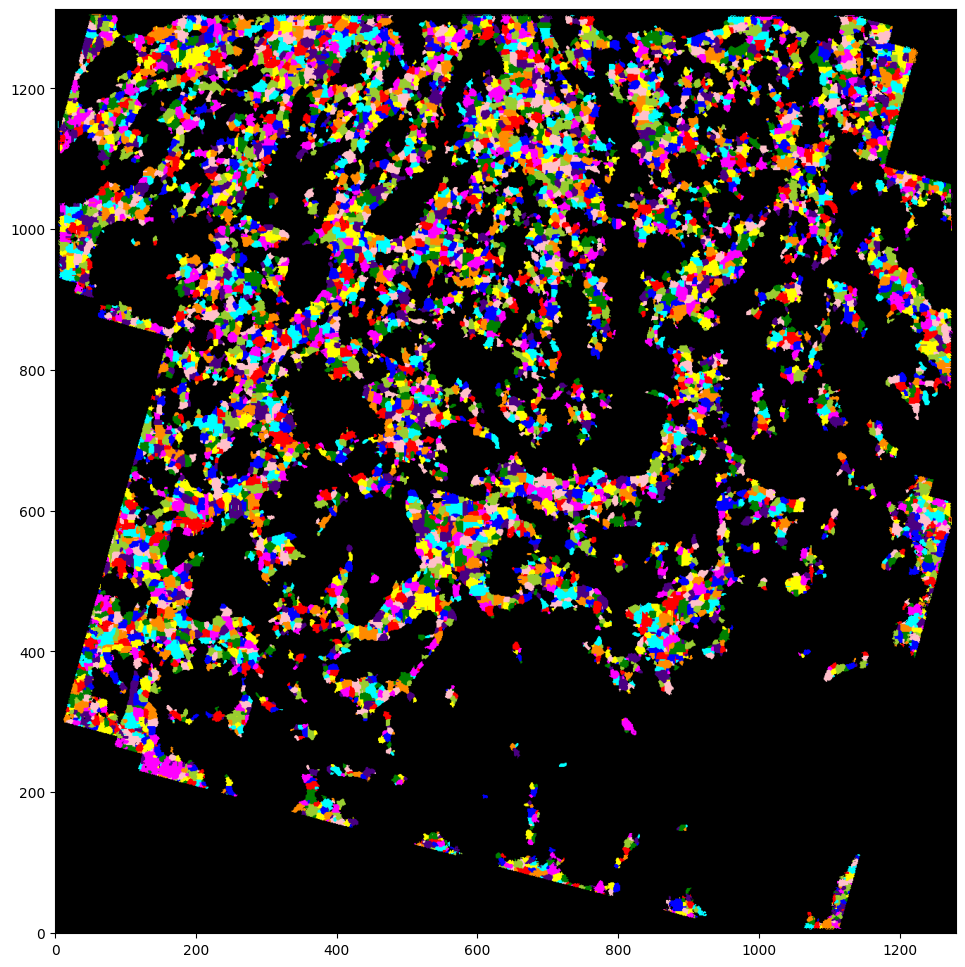

In [5]:
subImageS = np.zeros_like(rotated_im)
numBlobs = np.max(segmentationSouth)
print(numBlobs)
index = 0
label_coords = []
#Iterate over all blobs starting from 1 (label 0 is empty space)
for j in range(1,numBlobs):
    testBlob = np.where(segmentationSouth == j, rotated_im, 0)
    subblobs = blob_dog(testBlob, min_sigma=1, max_sigma=2, threshold=0.001)
    subblobs = np.round(subblobs).astype(int)
    labeled_clumps = np.zeros_like(testBlob, dtype=int)
    # Assign unique labels to the blobs

    for i, (y, x, sigma) in enumerate(subblobs):
        labeled_clumps[y,x] = index + 1
        index = index+1
    subSegmentation = watershed(-testBlob, labeled_clumps, mask=(testBlob > 0.001))
    #subOverlay = label2rgb(subSegmentation, bg_label=0)
    subImageS = subImageS+subSegmentation #Adds the cloud to the region image
fig, ax = plt.subplots(figsize = (16, 12))
subOverlay = label2rgb(subImageS, bg_label = 0)
ax.imshow(subOverlay, origin = "lower")






This cell calculates the major and minor axes of each cloud as if they were a ellipse.

Text(0, 0.5, 'Count')

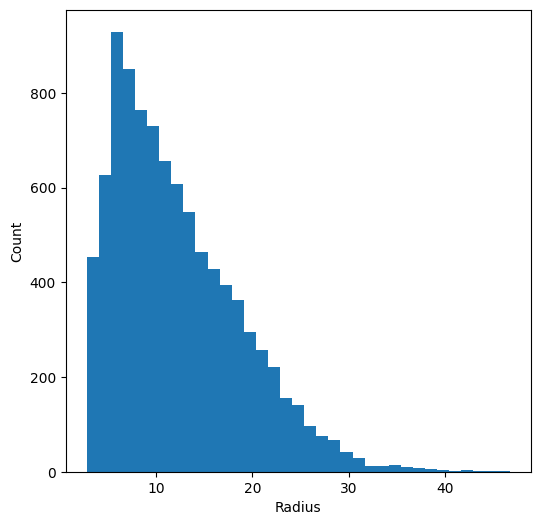

In [7]:
unique, counts = np.unique(subImageS, return_counts = True) #get label and number of pixels
imageCounts = dict(zip(unique, counts)) #Create dictionary such that imageCounts[label] = count
testArray = subImageS
for i in imageCounts:
    if imageCounts[i] < 4: #We cut off the minimum size at 4 pixels
        testArray = np.where(testArray!= i, testArray, 0)
ellipsStats = regionprops(testArray.astype(dtype=int)) #Calculate a whole bunch of stuff including major and minor axes
axesPx = []
for i in ellipsStats:
    #Some clouds are too small to get a minor axis for, exclude them. 
    if i.axis_minor_length == 0:
        continue
    axesPx.append((i.axis_major_length, i.axis_minor_length, i.label))
axes = [(i[0]*(5/3), i[1]*(5/3), i[2]) for i in axesPx] #The 5/3 is here because 1 px = 5/3 parsecs. This list is set up as [major, minor, label]
#Store volume
volumes = []
for i in axes:
    V = (4/3)*np.pi*i[0]*i[1]*i[1] #Volume of ellipsoid
    volumes.append(V)
#Estimate spherical radius
sphereRadii = []
for i in volumes:
    R = ((3*i)/(4*np.pi))**(1/3) #Radius calculated with ellipsoidal volume
    sphereRadii.append(R)

fig, ax = plt.subplots(figsize = (6, 6))
ax.hist(sphereRadii, bins=35)
ax.set_xlabel("Radius")
ax.set_ylabel("Count")




Calculate Number Density

In [8]:
numDensity = []
colDensity = []
cloudLabels = []
print(np.unique(testArray.astype(dtype=int)))
print(len(axes))
for i in axesPx:
    reg = np.where(testArray == i[2], rotated_im, 0) #Uses the label to mask all of the raw image except for the cloud
    I = np.sum(reg) #Sums up all the array entries
    n = 5.54*(I**1.15)/(i[1]) #Calculate number density (i[1] is the minor axis)
    N = 0.285*(10**20)*(I**1.15)
    numDensity.append(n) 
    colDensity.append(N)
    cloudLabels.append(i[2]) #We still need to keep track of the labels that the watershed gave each cloud

[    0     1     2 ...  9998  9999 10000]
9264


814.8370157629005


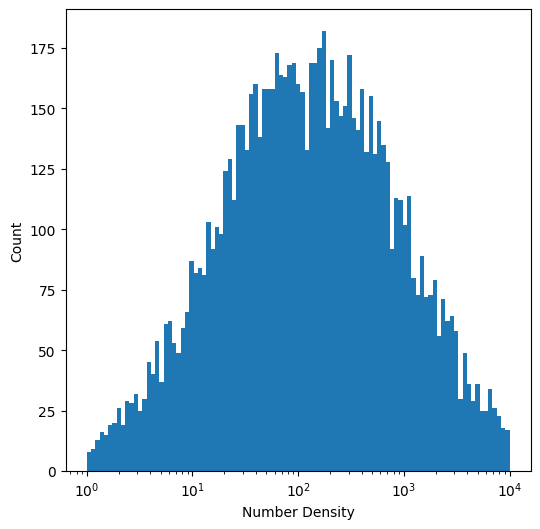

In [9]:
fig, ax = plt.subplots(figsize = (6,6))
ax.hist(numDensity, bins=np.logspace(np.log10(1), np.log10(1e4), 100), range=(1, 1e4))
ax.set_xlabel("Number Density")
ax.set_xscale("log")
ax.set_ylabel("Count")
print(np.mean(numDensity))

In [10]:
YOFFSET = 222
XORIGIN = 552.7
YORIGIN = 1313
#The image is offset from the galactic center, so distances need to be corrected
relCords = []
for i in axesPx:
    #This loop calculates image coordinates relative to the desired origin
    if i[2] == 0:
        continue
    coords = np.argwhere(subImageS == i[2])
    min_y, min_x = np.min(coords, axis=0)
    max_y, max_x = np.max(coords, axis=0)
    y, x = (YORIGIN-(min_y + max_y)/2), ((min_x+max_x)/2)-XORIGIN
    relCords.append([x, y, i[2]])


In [11]:
dist = []
for i in relCords:
    #Convert image coordinates to distance to galactic center in pc
    x, y = (5/3)*i[0], (5/3)*i[1]
    d = np.sqrt((x**2)+((y+YOFFSET)**2))
    dist.append(d)


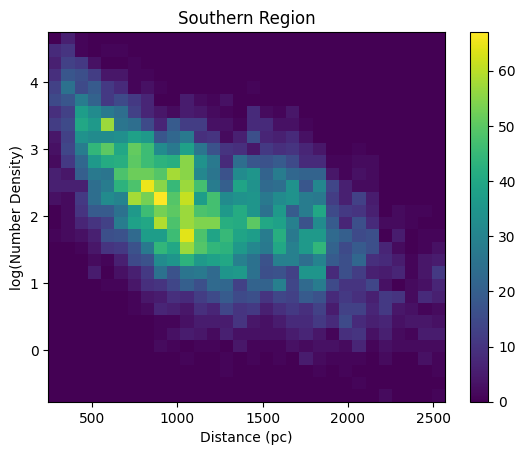

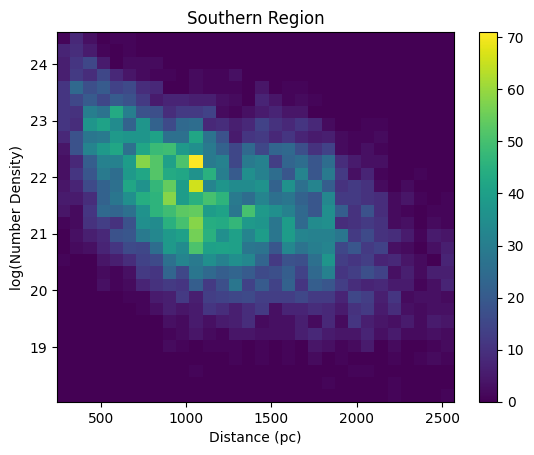

In [12]:
fig, ax = plt.subplots()
lDense = [np.log10(i) for i in numDensity] #Plot looks better doing the log scaling like this
h = ax.hist2d(dist, lDense, bins=(30, 30)) #Make the histogram
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Southern Region")
fig.colorbar(h[3])
#plt.savefig("Southern2dhist.png", format="png")

fig, ax =plt.subplots()
h = ax.hist2d(dist, np.log10(colDensity), bins=(30, 30))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Southern Region")
fig.colorbar(h[3])

In [13]:
northDensities = np.loadtxt("NorthDensities.csv", dtype=float, delimiter=",") #CSVs calculated in NorthAnalysis.ipynb
northDistances = np.loadtxt("NorthDistances.csv", dtype=float, delimiter=",")
northColDensity = np.loadtxt("NorthColDensity.csv", dtype=float, delimiter=",")
northRadii = np.loadtxt("NorthRadii.csv", dtype=float, delimiter=',')

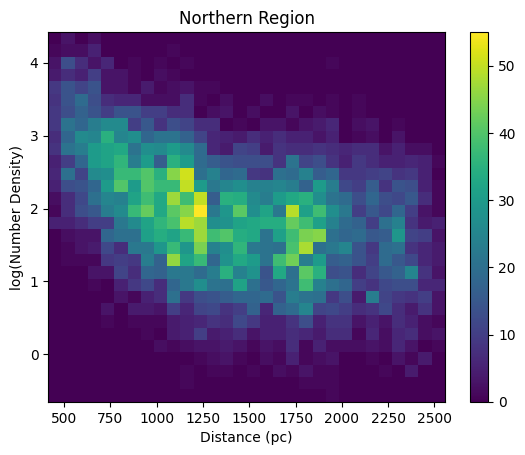

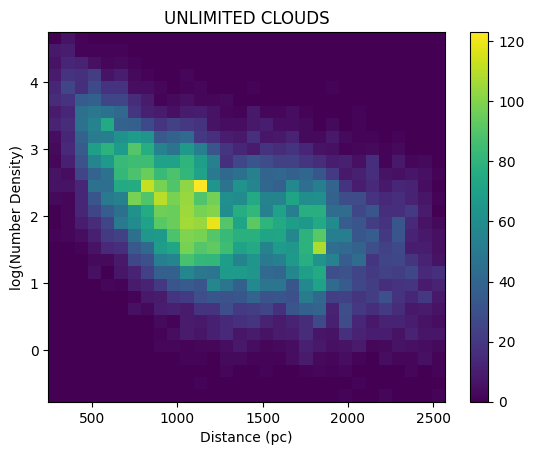

In [14]:
fig, ax = plt.subplots()
lDense = [np.log10(i) for i in northDensities] #Plot looks better doing the log scaling like this
h = ax.hist2d(northDistances, lDense, bins=(30, 30)) #Make the histogram
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Northern Region")
fig.colorbar(h[3])
southDensities = np.array(numDensity)
southDistances = np.array(dist)

combinedDensities = np.append(southDensities, northDensities) #Combine this data with north region data
combinedDistances = np.append(southDistances, northDistances)
combinedColDensities = np.append(colDensity, northColDensity)
combinedRadii = np.append(sphereRadii, northRadii)


fig, ax = plt.subplots()
h = ax.hist2d(combinedDistances, np.log10(combinedDensities), bins=(30, 30)) #Make the histogram
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("UNLIMITED CLOUDS")
fig.colorbar(h[3])

np.savetxt("combinedDens.csv", combinedDensities, fmt="%f", delimiter=",") #Save the CSVs
np.savetxt("combinedDist.csv", combinedDistances, fmt="%f", delimiter=",")
np.savetxt("combinedColDensity.csv", combinedColDensities, fmt="%f", delimiter=",")
np.savetxt("combinedRadii.csv", combinedRadii, fmt='%f', delimiter=',')